In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import os
import re


In [3]:
image_datas = glob('./chinese_foods/*/*.jpg')
class_name = ["congee", "dong_po_rou", "baozi", "chaofan", "zhajiangmian",
                  "sweet_and_sour_pork", "mapotofu", "wonton_soup", "mooncake", "pecking_duck"]
dic = {"congee":0, "dong_po_rou":1, "baozi":2, "chaofan":3, "zhajiangmian":4,
                  "sweet_and_sour_pork":5, "mapotofu":6, "wonton_soup":7, "mooncake":8, "pecking_duck":9}

In [4]:
X = []
Y = []
for imagename in image_datas:
    image = Image.open(imagename)
    image = image.resize((128, 128))
    image = np.array(image)
    X.append(image)
    label = imagename.split('\\')[2].replace('.jpg','').replace(' ','')
    label = re.sub(r"[0-9]", "", label)
    label = label[:-1]
    label = dic[label]
    Y.append(label)

In [5]:
X = np.array(X)    
Y = np.array(Y)  

In [6]:
train_images, test_images, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, 
                                                    shuffle=True, random_state=44)

train_labels = train_labels[..., tf.newaxis]
test_labels = test_labels[..., tf.newaxis]

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((875, 128, 128, 3), (875, 1), (219, 128, 128, 3), (219, 1))

In [7]:
## training set의 각 class 별 image 수 확인
unique, counts = np.unique(np.reshape(train_labels, (875,)), axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 86, 1: 99, 2: 79, 3: 97, 4: 66, 5: 93, 6: 87, 7: 93, 8: 83, 9: 92}

In [8]:
## test set의 각 class 별 image 수 확인
unique, counts = np.unique(np.reshape(test_labels, (219,)), axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 26, 1: 25, 2: 27, 3: 25, 4: 19, 5: 17, 6: 20, 7: 21, 8: 18, 9: 21}

In [9]:
N_TRAIN = train_images.shape[0]
N_TEST = test_images.shape[0]

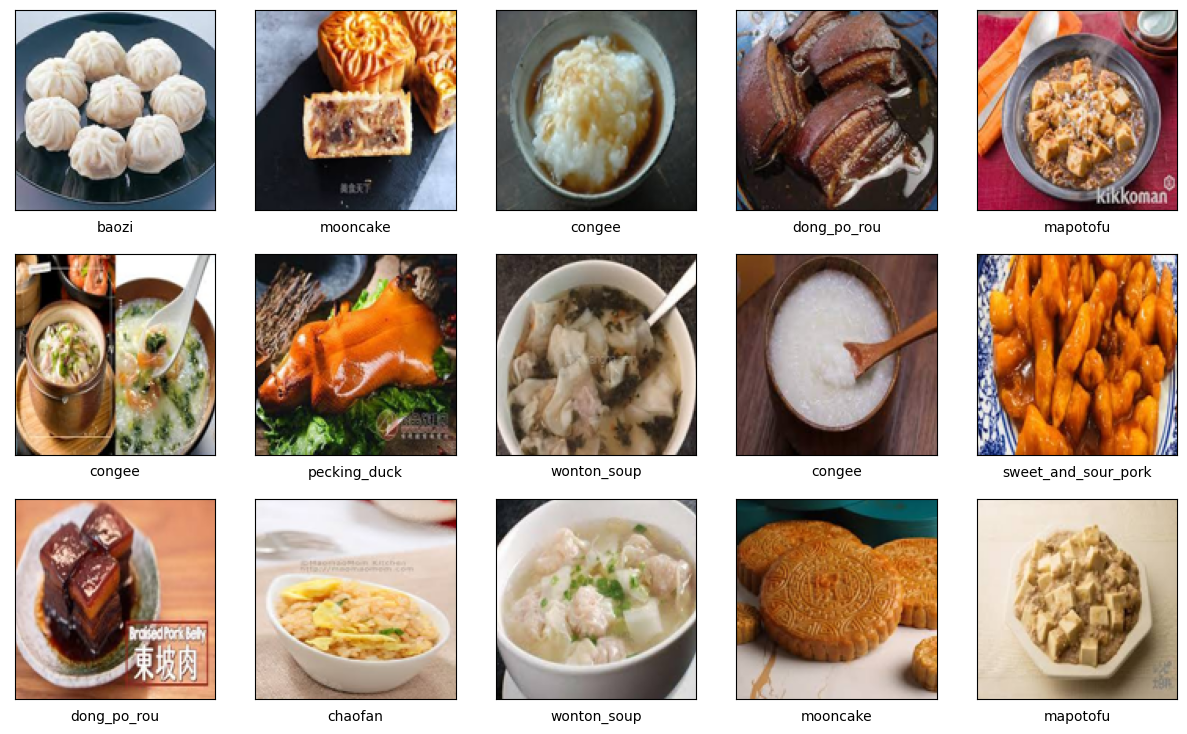

In [10]:
## Data 확인
plt.figure(figsize=(15,9))
for i in range(15):
    img_idx = np.random.randint(0, 875)
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[img_idx])
    plt.xlabel(class_name[train_labels[img_idx][0]])


In [11]:
# pixel값을 0~1사이 범위로 조정
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

# label을 onehot-encoding
train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

In [12]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(875, 128, 128, 3) (875, 10)
(219, 128, 128, 3) (219, 10)


In [36]:
## Hyper-parameters
learning_rate = 0.01
N_EPOCHS = 35
N_BATCH = 30
N_CLASS = 10

In [37]:
## dataset 구성    
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=875).batch(N_BATCH).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(
				N_BATCH)

In [39]:
# Sequential API를 사용하여 model 구성
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, 
                                  activation='relu', padding='SAME', 
                                  input_shape=(128, 128, 3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, 
                                  activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, 
                                  activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [40]:
## Create model, compile & summary
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 128)     

In [41]:
## Parameters for training
steps_per_epoch = N_TRAIN//N_BATCH
validation_steps = N_TEST//N_BATCH
print(steps_per_epoch, validation_steps)

875
29 7


In [42]:
## Training
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train_dataset, epochs=N_EPOCHS, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps,     callbacks=[early_stopping]
)

Epoch 1/35
29/29 [==============================] - 11s 349ms/step - loss: 9.2993 - accuracy: 0.1034 - val_loss: 2.2940 - val_accuracy: 0.0810
Epoch 2/35
29/29 [==============================] - 10s 357ms/step - loss: 2.2945 - accuracy: 0.1172 - val_loss: 2.2645 - val_accuracy: 0.1762
Epoch 3/35
29/29 [==============================] - 10s 355ms/step - loss: 2.2031 - accuracy: 0.1834 - val_loss: 2.1083 - val_accuracy: 0.1952
Epoch 4/35
29/29 [==============================] - 10s 334ms/step - loss: 2.2246 - accuracy: 0.1964 - val_loss: 2.1029 - val_accuracy: 0.1952
Epoch 5/35
29/29 [==============================] - 10s 346ms/step - loss: 1.9916 - accuracy: 0.2675 - val_loss: 1.9351 - val_accuracy: 0.2095
Epoch 6/35
29/29 [==============================] - 10s 357ms/step - loss: 1.9216 - accuracy: 0.2615 - val_loss: 1.9670 - val_accuracy: 0.2524
Epoch 7/35
29/29 [==============================] - 10s 347ms/step - loss: 1.8027 - accuracy: 0.3266 - val_loss: 1.8810 - val_accuracy: 0.2333

In [43]:
model.evaluate(test_dataset)

8/8 [==============================] - 1s 76ms/step - loss: 4.7321 - accuracy: 0.2146


[4.732100963592529, 0.21461187303066254]

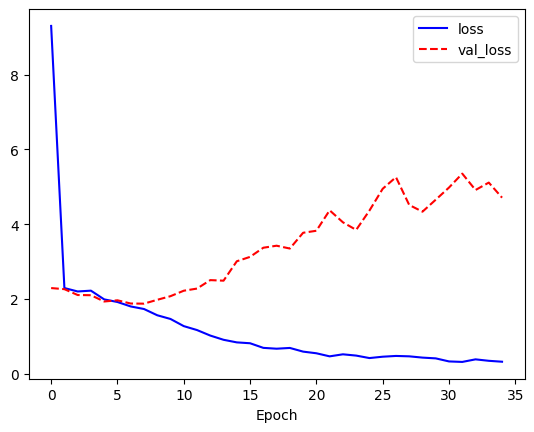

In [44]:
## Plot losses
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

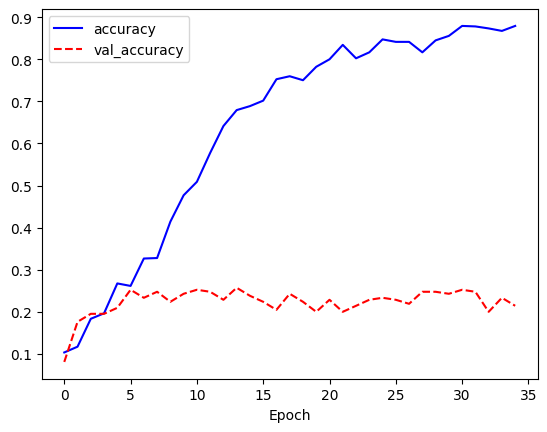

In [45]:
## Plot accuracy
plt.plot(history.history['accuracy'], 'b-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [46]:
## 결과 확인
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_name[predicted_label],
                                100*np.max(predictions_array),
                                class_name[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(N_CLASS), class_name, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(N_CLASS), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

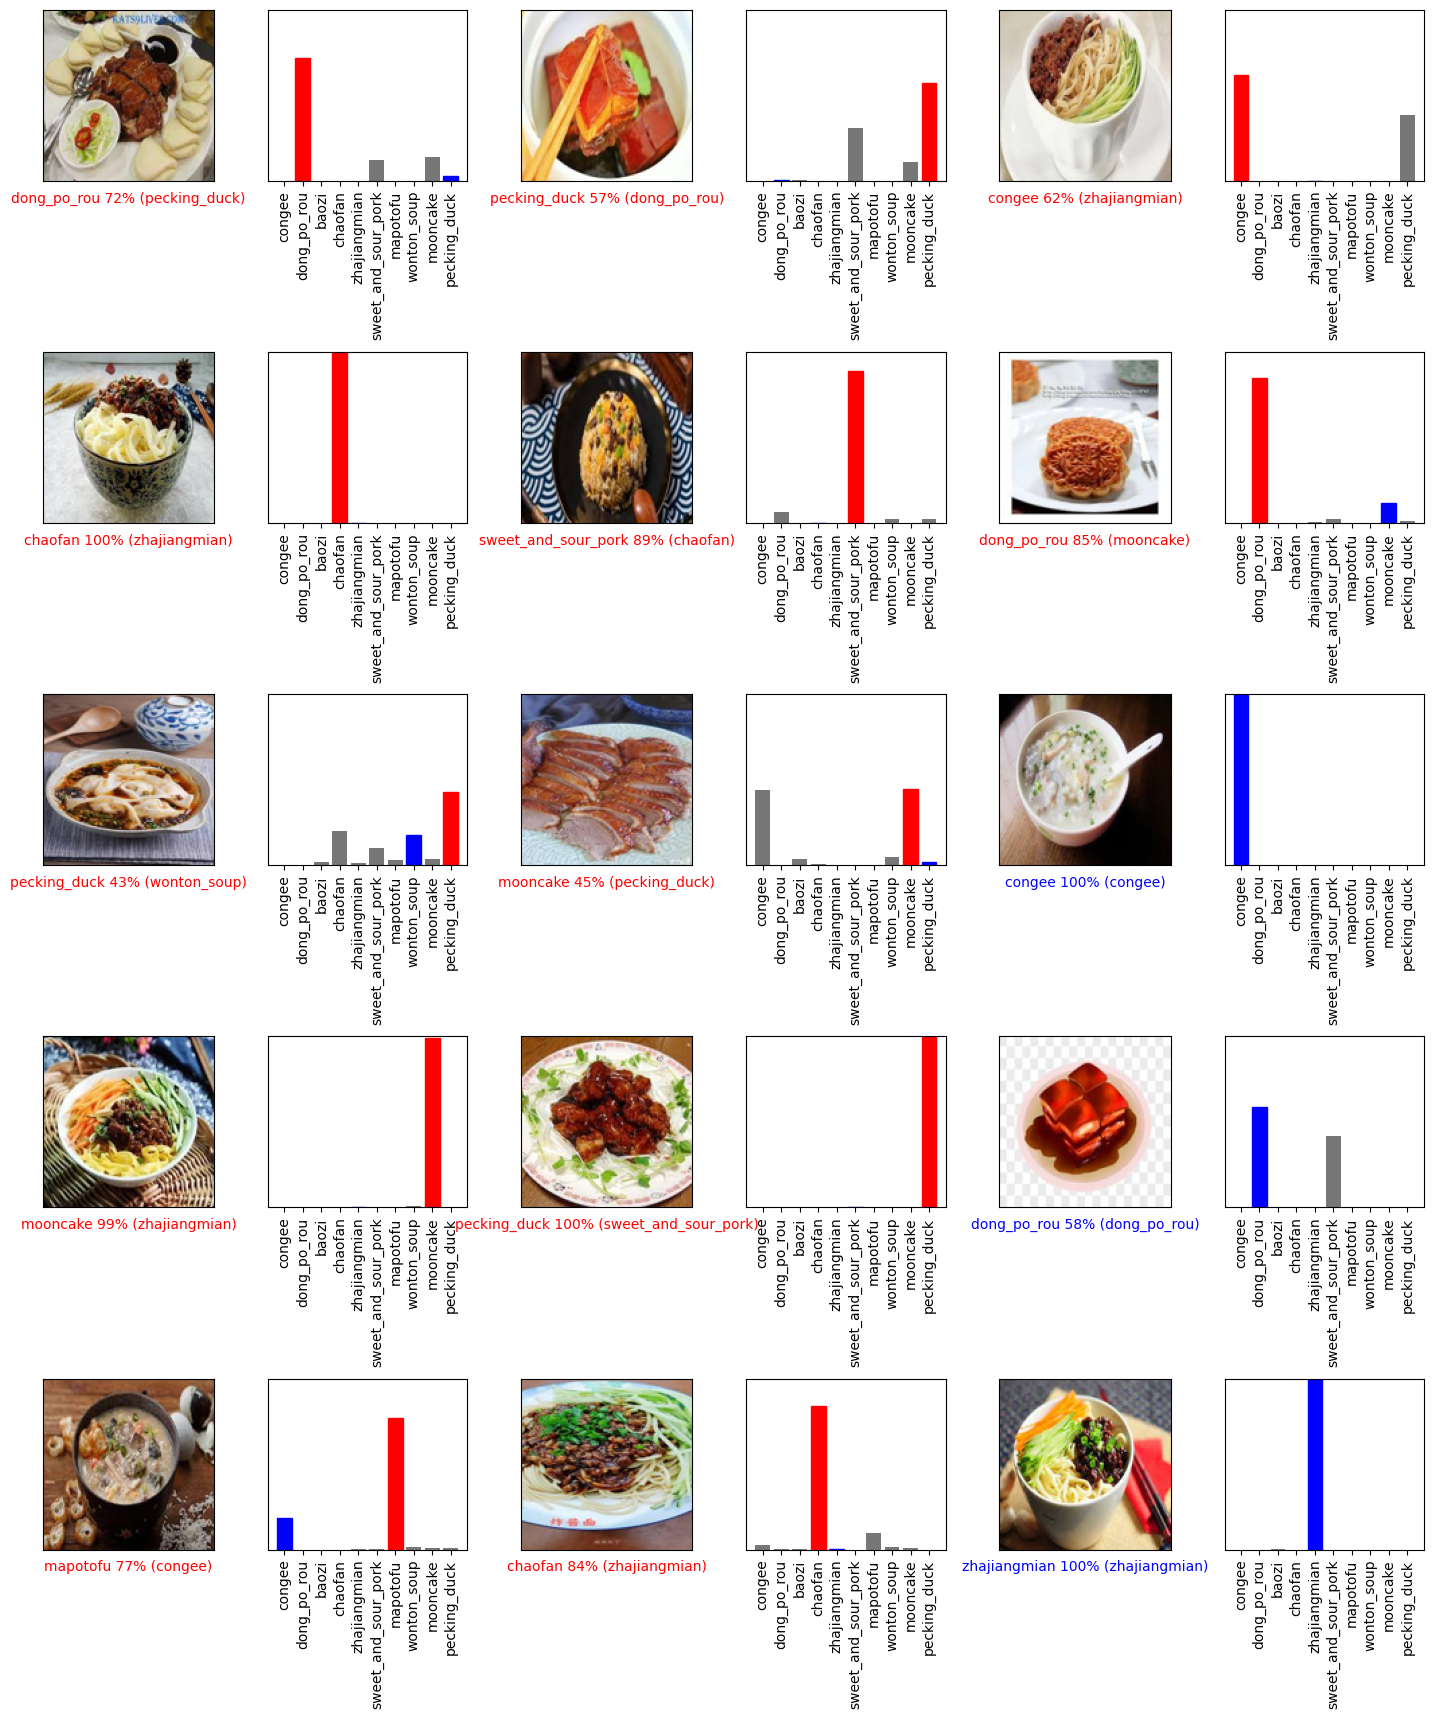

In [47]:
rnd_idx = np.random.randint(1, N_TEST//N_BATCH)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = model(images, training=False)
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions.numpy(), labels.numpy())        
    break